In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from torch.nn import init
from torch.nn import functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# Data augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10, fill=(0,)),
    transforms.ToTensor(),
])

In [18]:
root = 'dataset/'
if not os.path.exists(root):
    os.mkdir(root)

# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root=root,
                                     train=True,
                                     transform=transform,
                                     download=True)

In [19]:
# Creating a validation split
train_data, val_data = random_split(dataset, [50000, 10000])

train_loader = DataLoader(train_data, batch_size=32)
val_loader = DataLoader(val_data, batch_size=32)

In [20]:
# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)

In [21]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
criterion = nn.CrossEntropyLoss()

In [22]:
# Initialization of the variables
min_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 4  # Define your own early stopping criteria
train_losses = []
val_losses = []

In [23]:
# Training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

In [24]:
# Testing loop
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Save misclassified images, labels, and predictions
            wrong_idx = (pred.eq(target.view_as(pred)) == False).nonzero()[:, 0] # indices where the prediction is wrong
            misclassified_images.append(data[wrong_idx])
            misclassified_labels.append(target[wrong_idx])
            misclassified_preds.append(pred[wrong_idx])

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # Concatenate all the tensors along the 0 dimension
    misclassified_images = torch.cat(misclassified_images)
    misclassified_labels = torch.cat(misclassified_labels)
    misclassified_preds = torch.cat(misclassified_preds)

    return test_loss, misclassified_images, misclassified_labels, misclassified_preds

In [25]:
epochs = 10
for epoch in range(1, epochs + 1):
    print(epoch)
    train(model, device, train_loader, optimizer, epoch)
    val_loss, misclassified_images, misclassified_labels, misclassified_preds = test(model, device, val_loader)
    val_losses.append(val_loss)
    # Save model if validation loss decreased
    if val_loss < min_val_loss:
        torch.save(model.state_dict(), 'model.pt')
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
    # Early stopping
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break
    scheduler.step()

1

Test set: Average loss: 0.0027, Accuracy: 9757/10000 (98%)

2

Test set: Average loss: 0.0021, Accuracy: 9801/10000 (98%)

3

Test set: Average loss: 0.0020, Accuracy: 9822/10000 (98%)

4

Test set: Average loss: 0.0019, Accuracy: 9836/10000 (98%)

5

Test set: Average loss: 0.0019, Accuracy: 9847/10000 (98%)

6

Test set: Average loss: 0.0017, Accuracy: 9860/10000 (99%)

7

Test set: Average loss: 0.0016, Accuracy: 9864/10000 (99%)

8

Test set: Average loss: 0.0016, Accuracy: 9862/10000 (99%)

9

Test set: Average loss: 0.0017, Accuracy: 9866/10000 (99%)

10

Test set: Average loss: 0.0017, Accuracy: 9870/10000 (99%)



AttributeError: 'float' object has no attribute 'item'

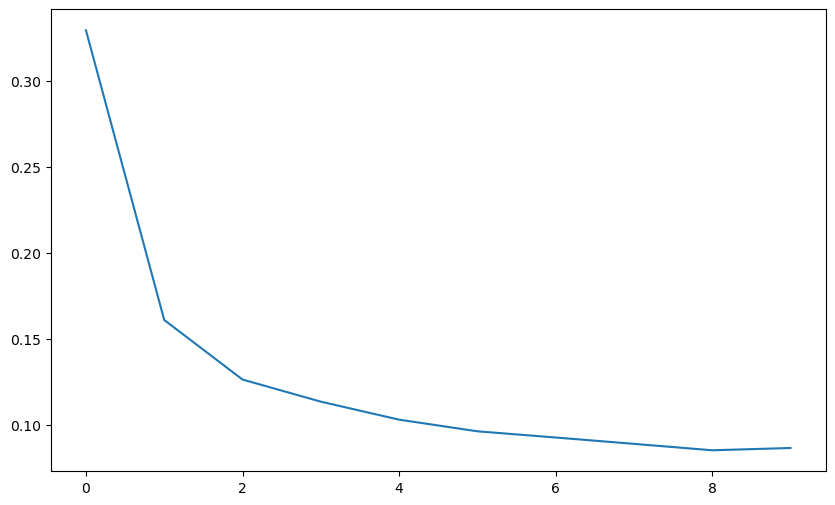

In [26]:
# After all epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot([loss.item() for loss in val_losses], label='Validation Loss')  # Converts tensor to python scalar
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Train vs Validation Loss', fontsize=14)
plt.legend()
plt.show()


Test set: Average loss: 0.0015, Accuracy: 9871/10000 (99%)



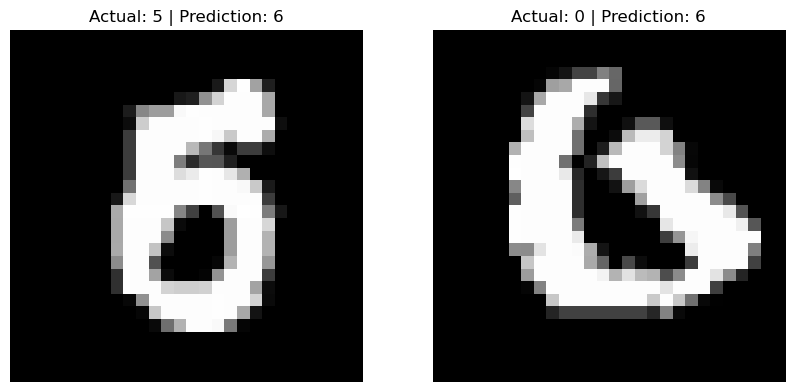

In [27]:
_, misclassified_images, misclassified_labels, misclassified_preds = test(model, device, val_loader)

# Choose random misclassified images
num_images = min(2, len(misclassified_images)) # to ensure we have at least 2 images
random_indices = np.random.choice(len(misclassified_images), size=num_images, replace=False)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    image, label, pred = misclassified_images[idx], misclassified_labels[idx], misclassified_preds[idx]
    plt.subplot(1, num_images, i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray') # squeeze to remove color channel
    plt.title(f"Actual: {label.item()} | Prediction: {pred.item()}")
plt.show()